In [2]:
import numpy as np
from pathlib import Path
import h5py
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from numpy.linalg import norm
import torch
import sys
sys.path.append('../')
sys.path.append('../training/')

from KS import KS
import diagnostics


plt.rcParams.update({
    "text.usetex": True,
    "font.size": '16',
})

In [3]:
color_palette = sns.color_palette("colorblind")

In [4]:
ks = KS(L=22.0, K=15, dt=0.01)

In [5]:
pdata = Path('../data/trajectory.hdf5')
ppos = Path('../data/5POs_L22.000.hdf5')

try:
    fdata = h5py.File(pdata, 'r')
    sol = fdata["sol"][:, :]
    sol_ = fdata['sol_'][:, :]
    tt_sol = fdata["tt"][()]
    fdata.close()
except:
    # random trajectory
    np.random.seed(42)
    ic = ks.flow(np.random.randn(ks.d) * 0.01, 100)
    tt_sol = np.arange(0, 1000, 0.01)
    sol = odeint(ks.rhs, ic, tt)
    sol_ = ks.symmreduce(sol)

    fdata = h5py.File(pdata, 'w')

    # gsol = fdata.create_group('sol')
    fdata['sol'] = sol
    fdata['sol_'] = sol_
    fdata['tt'] = tt
    fdata.close()

fpos = h5py.File(ppos, 'r')
pos = {}

for ipo, po in enumerate(fpos.keys()):

    pos[po] = {}
    for key in fpos[po].keys():
        pos[po][key] = fpos[po][key][()]
    
    xi_p = pos[po]['xi_p']
    T_p = pos[po]['T_p']
    tt = np.arange(0, T_p, 0.01)
    
    if pos[po]['translation'] and pos[po]['reflection']:
        xi_p = ks.SO2_operator(- pos[po]['phi_p'] / 2) @ xi_p
    
    sol_po = odeint(ks.rhs, xi_p, tt)
    red_sol_po = ks.symmreduce(sol_po)
    pos[po]['sol'] = sol_po
    pos[po]['red_sol'] = red_sol_po

fpos.close()

In [6]:
po = '32.80'

xi_p = pos[po]['xi_p']
T_p = pos[po]['T_p']

tt_p = np.arange(0, T_p, ks.dt)
sol_po = odeint(ks.rhs, xi_p, tt_p)

sol_po_ = ks.symmreduce(sol_po)
pca = PCA(n_components=3).fit(sol_po_)
po_pca = pca.transform(sol_po_)

J_p = pos[po]['J_p']

LA_p, PS_p = np.linalg.eig(J_p)

i_sort = np.argsort(np.abs(LA_p))[::-1]
LA_p = LA_p[i_sort]
PS_p = PS_p[:, i_sort]

mu = np.log(np.abs(LA_p[0])) / T_p 

if np.imag(LA_p[0]) == 0 and np.real(LA_p[0]) < 0:
    # non-orientable neighborhood
    om = np.abs(np.angle(LA_p[0])) / T_p

    i_mu_s = np.argwhere(np.abs(LA_p) - 1 < -1e-3).reshape(-1)[0]
    mu_s = np.log(np.real(np.abs(LA_p[i_mu_s]))) / T_p 
elif not(np.angle(LA_p[0]) == 0):
    # spiraling neighborhood
    om = np.abs(np.angle(LA_p[0])) / T_p
    mu_s = 0
else:
    # expanding/contracting neighborhood
    om = 0
    i_mu_s = np.argwhere(np.abs(LA_p) - 1 < -1e-3).reshape(-1)[0]
    mu_s = np.log(np.real(np.abs(LA_p[i_mu_s]))) / T_p 

In [7]:
pars = diagnostics.read_parameters("../models/parameters_po1.txt")
conjnet = diagnostics.get_conjnet(pars, ckpt="../models/conjnet_po_1.ckpt")
pos[po]["conjnet"] = conjnet

no kom parameter found, setting kom=0


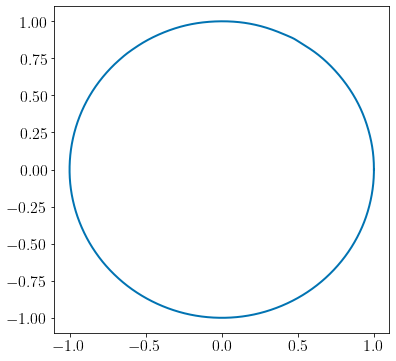

In [8]:
torch_sol_po_ = torch.tensor(sol_po_)
latent_po = conjnet.encoder(torch_sol_po_).detach().numpy()
decoder_po = conjnet.decoder(conjnet.encoder(torch_sol_po_)).detach().numpy()

fig = plt.figure(figsize=(6,6))
ax = plt.gca()
ax.plot(latent_po[:, 0], latent_po[:, 1], color=color_palette[0], lw=2.0)

In [9]:
def align_state(xi_red, xi_0):
    
    d = xi_red.shape[0]
    pi = np.pi
    inv_xi_red = ks.inv_symmreduce(xi_red)
    
    # aligning the initial state with 
    cxi_0 = xi_0[0:d:2] + 1j * xi_0[1:d:2]
    slice_phase_0 = (np.angle(cxi_0[1]) - pi/2) / 2 
    
    ref_inv_xi_red = ks.reflection_matrix @ inv_xi_red

    inv_xi_red_shift = ks.SO2_operator(slice_phase_0) @ inv_xi_red
    inv_xi_red_shift_ = ks.SO2_operator(slice_phase_0 + pi) @ inv_xi_red
    ref_inv_xi_red_shift = ks.SO2_operator(slice_phase_0) @ ref_inv_xi_red
    ref_inv_xi_red_shift_ = ks.SO2_operator(slice_phase_0 + pi) @ ref_inv_xi_red

    dists = np.zeros(4)
    dists[0] = norm(inv_xi_red_shift - xi_0)
    dists[1] = norm(inv_xi_red_shift_ - xi_0)
    dists[2] = norm(ref_inv_xi_red_shift - xi_0)
    dists[3] = norm(ref_inv_xi_red_shift_ - xi_0)

    mindist = np.min(dists)

    if mindist == dists[0]:
        reflect = False
    elif mindist == dists[1]:
        reflect = False
        slice_phase_0 += pi
    elif mindist == dists[2]:
        reflect = True
    else:
        reflect=True
        slice_phase_0 += pi
    
    xi = inv_xi_red
    
    if reflect:
        xi = (ks.reflection_matrix @ xi).transpose() 

    xi = (ks.SO2_operator(slice_phase_0) @ xi).transpose()
        
    return xi

In [10]:
def rhs_control(xi, t, ep_ae = 0.2, G = 1, dissip_th = 0.5):
    
    xi_red = ks.symmreduce(xi)
    xi_ae =  conjnet.decoder(
        conjnet.encoder(
            torch.tensor(xi_red)
        )
    ).detach().cpu().numpy()
    rerr_ae = norm(xi_ae - xi_red) / norm(xi_red)
    
    if rerr_ae > ep_ae or ks.dissipation(xi) < dissip_th:
        return ks.rhs(xi, t)
    else:
        
        et = conjnet.encoder(torch.tensor(xi_red)).detach().cpu().numpy()
        
        control_dir = et / norm(et) - et

        et_c = et + G * control_dir
        xi_red_c = conjnet.decoder(torch.tensor(et_c)).detach().cpu().numpy()
        xi_red_c_aligned = align_state(xi_red_c, xi)
        rhs_c = xi_red_c_aligned - xi
        return ks.rhs(xi, t) + rhs_c

In [11]:
controlled_sol = odeint(rhs_control, xi_p, tt_p, args=(0.1,0.6,0.5))

In [12]:
controlled_sol_pca = pca.transform(ks.symmreduce(controlled_sol))

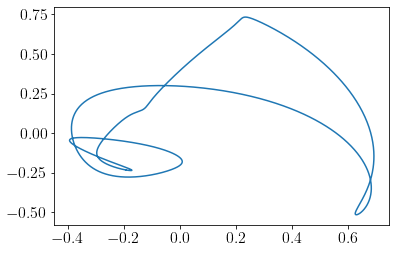

In [13]:
plt.plot(controlled_sol_pca[:, 0], controlled_sol_pca[:, 1])

Text(0.5, 1.0, 'control on')

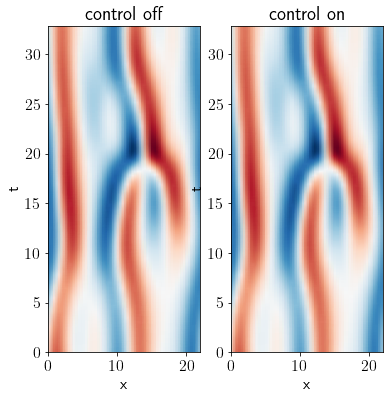

In [14]:
fig, axes = plt.subplots(1,2,figsize=(6,6))

ks.plot_spacetime(sol_po, tt_p, ax=axes[0])
ks.plot_spacetime(controlled_sol, tt_p, ax=axes[1])
axes[0].set_title("control off")
axes[1].set_title("control on")

In [15]:
xi_0_control = sol[0, :]
tt_control = np.arange(0, 400, 0.01)
sol_control = odeint(rhs_control, xi_0_control, tt_control, args=(0.1,0.4,0.5))

In [16]:
dissip_sol = ks.dissipation(sol)
dissip_control = ks.dissipation(sol_control)

powerin_sol = ks.power_in(sol)
powerin_control = ks.power_in(sol_control)

sol_pca = pca.transform(ks.symmreduce(sol))
sol_control_pca = pca.transform(ks.symmreduce(sol_control))

(0.0, 400.0)

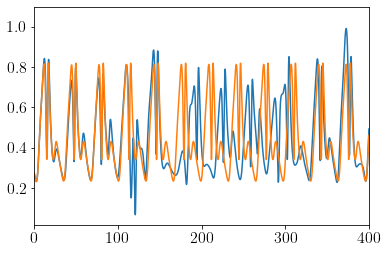

In [17]:
plt.plot(tt_sol, dissip_sol)
plt.plot(tt_control, dissip_control)
plt.xlim(0, 400)

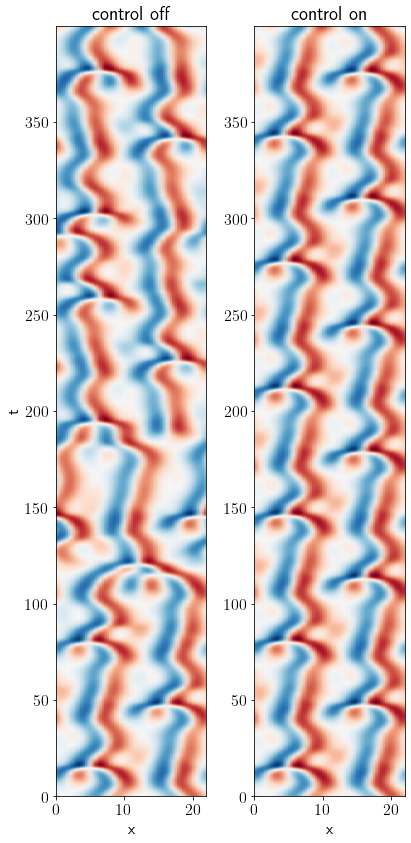

In [18]:
fig, axes = plt.subplots(1,2,figsize=(6,12))

ks.plot_spacetime(sol[:len(tt_control):10,:], tt_control[::10], ax=axes[0])
ks.plot_spacetime(sol_control[::10], tt_control[::10], ax=axes[1])
axes[0].set_title("control off")
axes[1].set_title("control on")
axes[1].set_ylabel("")
fig.tight_layout()

/tmp/ipykernel_100554/1113373508.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd['D'].set_xticklabels(xticklabels)


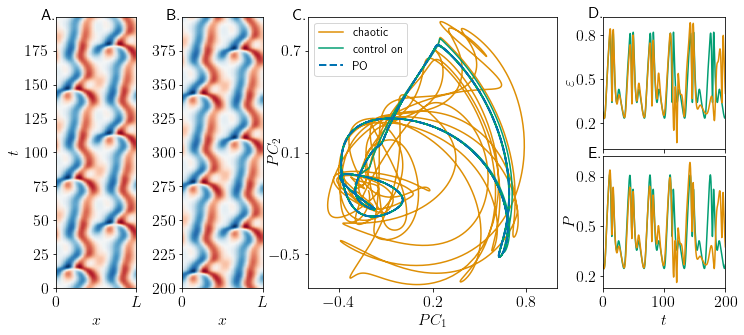

In [20]:
layout = """
    AAAAZZBBBBXXCCCCCCCCCCCCYYDDDDDD
    AAAAZZBBBBXXCCCCCCCCCCCCYYDDDDDD
    AAAAZZBBBBXXCCCCCCCCCCCCYYDDDDDD
    AAAAZZBBBBXXCCCCCCCCCCCCYYEEEEEE
    AAAAZZBBBBXXCCCCCCCCCCCCYYEEEEEE
    AAAAZZBBBBXXCCCCCCCCCCCCYYEEEEEE
"""
nskip = 10
ni_sol = 0
nf_sol = np.argwhere(tt_sol > 400.0)[0][0] - 1
n_half = nf_sol // 2

fig, axd = plt.subplot_mosaic(layout, figsize=(12,5))

for label in ['X', 'Y', 'Z']:
    axd[label].set_visible(False)

for label in ['A', 'B']:
    ax=axd[label]    
    ax.text(-0.18, 0.99, f"{label}.", transform=ax.transAxes)

axd['C'].text(-0.06, 0.99, 'C.', transform=axd['C'].transAxes)    
    
for label in ['D', 'E']:
    ax=axd[label]    
    ax.text(-0.11, 0.99, f"{label}.", transform=ax.transAxes)
        
    
ks.plot_spacetime(sol_control[ni_sol:n_half:nskip], tt_control[ni_sol:n_half:nskip], 
                  ax=axd['A'], vmin=-0.095, vmax=0.095)    
ks.plot_spacetime(sol_control[n_half:nf_sol:nskip], tt_control[n_half:nf_sol:nskip], 
                  ax=axd['B'], vmin=-0.095, vmax=0.095)    

axd['A'].set_xlabel("$x$")
axd['A'].set_ylabel("$t$")

axd['B'].set_xlabel("$x$")
axd['B'].set_ylabel('')
# yticks = axd['B'].get_yticks()
# yticklabels = []
# for tick in xticks:
#     yticklabels.append('')
# axd['B'].set_yticklabels(yticklabels)
for label in ['A', 'B']:
    axd[label].set_xticks([0, 22.0])
    axd[label].set_xticklabels(['$0$', '$L$  '])

axd['C'].plot(sol_pca[ni_sol:n_half, 0], sol_pca[ni_sol:n_half, 1], 
              color=color_palette[1], lw=1.5, label='chaotic')
axd['C'].plot(sol_control_pca[ni_sol:n_half, 0], sol_control_pca[ni_sol:n_half, 1], 
              color=color_palette[2], lw=1.5, label='control on')
axd['C'].plot(po_pca[:, 0], po_pca[:, 1], '--', 
              color=color_palette[0], lw=2.0, label='PO')
axd['C'].set_xlabel("$PC_1$")
axd['C'].set_ylabel("$PC_2$", labelpad=-12)

axd['C'].legend(fontsize=12)
axd['C'].set_yticks([-0.5, 0.1, 0.7])
axd['C'].set_xticks([-0.4, 0.2, 0.8])
axd['C'].set_ylim(-0.7, 0.9)
axd['C'].set_xlim(-0.6, 1.0)

axd['D'].plot(tt_control[ni_sol:n_half], dissip_control[ni_sol:n_half], color=color_palette[2], lw=1.5)
axd['D'].plot(tt_sol[ni_sol:n_half], dissip_sol[ni_sol:n_half], color=color_palette[1], lw=1.5)
axd['E'].plot(tt_control[ni_sol:n_half], powerin_control[ni_sol:n_half], color=color_palette[2], lw=1.5)
axd['E'].plot(tt_sol[ni_sol:n_half], powerin_sol[ni_sol:n_half], color=color_palette[1], lw=1.5)

for label in ['D', 'E']:
    axd[label].set_xlim(0, 200)
    axd[label].set_yticks([0.2, 0.5, 0.8])
#     axd[label].legend(fontsize=12, loc=4)    

axd['D'].set_xlabel('')
xticks = axd['D'].get_xticks()
xticklabels = []
for tick in xticks:
    xticklabels.append('')
axd['D'].set_xticklabels(xticklabels)

axd['D'].set_ylabel("$\\varepsilon$", labelpad=-1)
axd['E'].set_ylabel("$P$", labelpad=-1)
axd['E'].set_xlabel("$t$")

fig.savefig("stabilizing_control.png", dpi=200)

In [21]:
!/mpcdf/soft/SLE_15/packages/x86_64/imagemagick/7.1.1/bin/convert -trim stabilizing_control.png ../tex/fig/stabilizing_control.png